In [2]:
!pip install einops torch maze-dataset --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.7/145.7 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import os
import re
import numpy as np
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from tqdm import tqdm
from torch.nn import functional as F

now = datetime.now()
formatted_time = now.strftime("%Y%m%d_%H%M%S")
loss_curves_folder = f"../data/loss_curves_{formatted_time}/stable_diffusion_diffusion_models"
if not os.path.exists(loss_curves_folder):
    os.makedirs(loss_curves_folder)

In [4]:
os.chdir("..")
print(f"Current working directory: {os.getcwd()}")

Current working directory: /


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the Dataset

In [6]:
from collections import deque
import re
def generate_grid_world(size=10):
    num_walls = random.randint(0, 90)

    grid = [[1 for _ in range(size)] for _ in range(size)]

    wall_positions = set()
    while len(wall_positions) < num_walls:
        x, y = random.randint(0, size-1), random.randint(0, size-1)
        grid[x][y] = 0
        wall_positions.add((x, y))

    while True:
        start = (random.randint(0, size-1), random.randint(0, size-1))
        end = (random.randint(0, size-1), random.randint(0, size-1))
        if start != end and grid[start[0]][start[1]] == 1 and grid[end[0]][end[1]] == 1:
            break

    return grid, start, end

def bfs(grid, start, end):
    size = len(grid)
    queue = deque([(start[0], start[1], 0)])
    visited = set()
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    while queue:
        x, y, dist = queue.popleft()
        if (x, y) == end:
            return dist

        if (x, y) in visited:
            continue
        visited.add((x, y))

        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < size and 0 <= ny < size and (nx, ny) not in visited and grid[nx][ny] == 1:
                queue.append((nx, ny, dist + 1))

    return None

def generate_multiple_grid_worlds(num_worlds, size=10):
    maze_count = 0
    directory = "./data/mazes"

    os.makedirs(directory, exist_ok=True)

    with tqdm(total=num_worlds, desc="Generating Grid Worlds") as pbar:
        while maze_count < num_worlds:
            grid, start, end = generate_grid_world(size)
            path_length = bfs(grid, start, end)

            if path_length is not None:
                grid_world = np.zeros((size, size, 3), dtype=np.uint8)
                grid_world[:, :, 0] = grid
                grid_world[start[0], start[1], 1] = 1
                grid_world[end[0], end[1], 2] = 1

                maze_filename = os.path.join(directory, f"maze_{maze_count}.npy")
                path_length_filename = os.path.join(directory, f"path_length_{maze_count}.npy")
                np.save(maze_filename, grid_world)
                np.save(path_length_filename, path_length)

                maze_count += 1
                pbar.update(1)

In [7]:
import os
import numpy as np
from heapq import heappop, heappush
from tqdm import tqdm

from typing import Callable, Tuple

def load_maze(file_path):
    return np.load(file_path)

def get_coordinates(maze):
    source = np.argwhere(maze[:, :, 1] == 1)
    destination = np.argwhere(maze[:, :, 2] == 1)

    if len(source) == 0 or len(destination) == 0:
        return None, None

    return tuple(source[0]), tuple(destination[0])

def a_star(maze, distance_fn: Callable[[Tuple[int, int], Tuple[int, int]], int]):
    height, width, _ = maze.shape
    start, end = get_coordinates(maze)

    if start is None or end is None:
        return 0

    open_set = [(0, start)]
    g_scores = {start: 0}
    visited = set()
    nodes_explored = 0

    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    while open_set:
        _, (y, x) = heappop(open_set)
        nodes_explored += 1
        visited.add((y, x))

        if (y, x) == end:
            return nodes_explored - 2  # Exclude start and end nodes

        for dy, dx in directions:
            ny, nx = y + dy, x + dx

            if 0 <= ny < height and 0 <= nx < width and maze[ny, nx, 0] == 1:
                new_g = g_scores[(y, x)] + 1
                if (ny, nx) not in g_scores or new_g < g_scores[(ny, nx)]:
                    g_scores[(ny, nx)] = new_g
                    f_score = new_g + distance_fn((ny, nx), end)
                    heappush(open_set, (f_score, (ny, nx)))

    return nodes_explored - 2

def manhattan_distance(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

In [8]:
import numpy as np
import os
from collections import deque
from tqdm import tqdm

def load_maze(file_path):
    return np.load(file_path)

def numpy_to_ascii(maze_numpy):
    """Converts a (H, W, 3) NumPy array back to an ASCII maze string."""
    height, width, _ = maze_numpy.shape
    ascii_maze = np.full((height, width), " ", dtype="<U1")  # Default to paths (" ")

    ascii_maze[maze_numpy[:, :, 0] == 0] = "#"

    source_pos = np.argwhere(maze_numpy[:, :, 1] == 1)
    for y, x in source_pos:
        ascii_maze[y, x] = "S"

    dest_pos = np.argwhere(maze_numpy[:, :, 2] == 1)
    for y, x in dest_pos:
        ascii_maze[y, x] = "E"

    return "\n".join("".join(row) for row in ascii_maze)  # Convert array to ASCII string

def get_coordinates(maze):
    source = np.argwhere(maze[:, :, 1] == 1)  # 2nd channel == 1 -> Source
    destination = np.argwhere(maze[:, :, 2] == 1)  # 3rd channel == 1 -> Destination

    if len(source) == 0 or len(destination) == 0:
        print("Error Maze")
        print(maze)
        print(numpy_to_ascii(maze))
        return None, None

    return tuple(source[0]), tuple(destination[0])

def bfs_shortest_path(maze):
    """Finds the shortest path using BFS. Returns path length or -1 if unreachable."""
    height, width, _ = maze.shape
    start, end = get_coordinates(maze)

    if start is None or end is None:
        return 0

    queue = deque([(start[0], start[1], 0)])
    visited = set()
    nodes_explored = 0
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    while queue:
        y, x, dist = queue.popleft()
        nodes_explored += 1

        if (y, x) == end:
            return dist

        for dy, dx in directions:
            ny, nx = y + dy, x + dx

            if 0 <= ny < height and 0 <= nx < width and maze[ny, nx, 0] == 1 and (ny, nx) not in visited:
                queue.append((ny, nx, dist + 1))
                visited.add((ny, nx))

    return nodes_explored - 2 # exclude start and end

In [9]:

n_mazes = 25000
directory = "./data/mazes"

#generate_dataset(n_mazes, directory) ,
generate_multiple_grid_worlds(n_mazes, size = 10)

input_directory = './data/mazes'
output_directory = "./data/mazes/a_star_l1_results/"

os.makedirs(output_directory, exist_ok=True)

maze_files = [f for f in os.listdir(input_directory) if f.endswith(".npy") and "maze" in f]

with tqdm(total=len(maze_files), desc="Processing Mazes", unit="maze") as pbar:
    for file in maze_files:
        idx = int(file.split("_")[1].split(".")[0])
        file_path = os.path.join(input_directory, file)

        maze = np.load(file_path)
        nodes_explored = a_star(maze, manhattan_distance)

        output_file = os.path.join(output_directory, f"a_star_{idx}.npy")
        np.save(output_file, np.array(nodes_explored, dtype=np.int32))

        output_file = os.path.join(output_directory, f"a_star_{idx}.txt")
        with open(output_file, "w") as f:
            f.write(str(nodes_explored))

        pbar.update(1)

input_directory = './data/mazes'
output_directory = "./data/mazes/bfs_results/"

os.makedirs(output_directory, exist_ok=True)

maze_files = [f for f in os.listdir(input_directory) if f.endswith(".npy") and "maze" in f]

with tqdm(total=len(maze_files), desc="Processing Mazes", unit="maze") as pbar:
    for file in maze_files:
        idx = int(file.split("_")[1].split(".")[0])
        file_path = os.path.join(input_directory, file)

        maze = np.load(file_path)
        nodes_explored = bfs_shortest_path(maze)

        output_file = os.path.join(output_directory, f"bfs_{idx}.npy")
        np.save(output_file, np.array(nodes_explored, dtype=np.int32))

        output_file = os.path.join(output_directory, f"bfs_{idx}.txt")
        with open(output_file, "w") as f:
            f.write(str(nodes_explored))
        pbar.update(1)

Processing Mazes: 100%|██████████| 25000/25000 [00:13<00:00, 1896.65maze/s]


In [10]:
# from generator.maze.grid_world_generator import generate_multiple_grid_worlds
# from generator.maze.solvers.a_star_l1 import main as a_star_l1_paths
# from generator.maze.solvers.bfs import main as bfs_paths

# parent_directory = "./data"
# if not os.path.exists(parent_directory):
#     os.makedirs(parent_directory)
# # generates the mazes
# mazes = generate_multiple_grid_worlds(num_worlds=25000, parent_directory=parent_directory)
# # generate path travrsals
# a_star_l1_paths(parent_directory)
# bfs_paths(parent_directory)

In [11]:
def preprocess_image(image, target_size=32):
    image = np.array(image)
    scale_factor = target_size // image.shape[0]
    # image = np.kron(image, np.ones((scale_factor, scale_factor, 1)))

    # image = image.astype(np.float32) / 127.5 - 1
    image = image.astype(np.float32)
    image = torch.tensor(image).permute(2, 0, 1)
    image = F.interpolate(image.unsqueeze(0), size=(target_size, target_size), mode='nearest').squeeze(0)  # (3, 32, 32)

    return image

def plot_grid_world(grid):
    """
    Plots the given grid world.
    """
    wall = grid[:,:,0] == 0
    source = grid[:,:,1] == 1
    destination = grid[:,:,2] == 1

    img = np.ones((*wall.shape, 3), dtype=np.float32)  # White background
    img[wall] = np.array([0, 0, 0])  # Walls → Black
    img[source] = np.array([1, 0, 0])  # Source → Red
    img[destination] = np.array([0, 1, 0])  # Destination → Green

    return img

def load_dataset_from_npy(parent_directory="./data", target_size=32):
    images = []
    path_lengths = []
    num_nodes_traversed_astar = []
    num_nodes_traversed_bfs = []

    mazes_directory = os.path.join(parent_directory, "mazes")
    files = sorted([f for f in os.listdir(mazes_directory) if f.endswith(".npy")])

    for file in files:
        img = np.load(os.path.join(mazes_directory, file))
        if(img.shape != (10,10,3)):
            continue
        # mask = np.all(img == [0, 0, 255], axis=-1)
        # img[mask] = [255, 255, 255]
        # img = img[:-1, :-1]
        # image = preprocess_image(img, target_size)

        image = plot_grid_world(img)
        mask = np.all(image == [0, 0, 255], axis=-1)
        image[mask] = [255, 255, 255]
        image = preprocess_image(image, target_size)

        pattern = r'maze_(\d+)'
        match = re.search(pattern, file)
        num = 0
        if match:
            num = int(match.group(1))
        else:
            continue

        # base_name = os.path.splitext(file)[0]
        # len_filename = base_name + "_len.txt"
        len_filename = f"path_length_{num}" + ".npy"
        len_path = os.path.join(mazes_directory, len_filename)
        astar_traversal_filename = f"a_star_{num}" + ".npy"
        astar_traversal_path = os.path.join(mazes_directory, "a_star_l1_results" ,astar_traversal_filename)
        bfs_traversal_filename = f"bfs_{num}" + ".npy"
        bfs_traversal_path = os.path.join(mazes_directory, "bfs_results" ,bfs_traversal_filename)

        # with open(len_path, "r") as f:
        #     maze_length = int(f.read().strip())
        maze_length = np.load(len_path)
        astar_traversal = np.load(astar_traversal_path)
        bfs_traversal = np.load(bfs_traversal_path)

        images.append(image)
        path_lengths.append(int(maze_length))
        num_nodes_traversed_astar.append(int(astar_traversal))
        num_nodes_traversed_bfs.append(int(bfs_traversal))

    return images, path_lengths, num_nodes_traversed_astar, num_nodes_traversed_bfs

In [12]:
mazes_data_path = "./data/"
images, org_path_lengths, num_nodes_astar, num_nodes_bfs = load_dataset_from_npy(mazes_data_path, target_size=32)

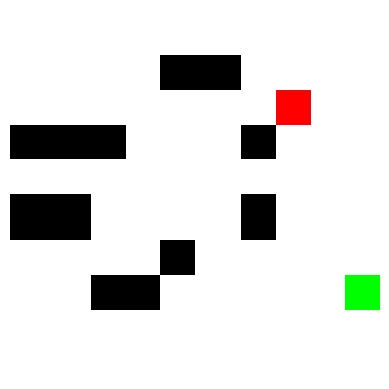

In [13]:
plt.imshow(images[0].permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

In [14]:
# # print(f"Current working directory: {os.getcwd()}")
# os.chdir("./diffuser")
# print(f"Current working directory: {os.getcwd()}")

## VAE Training

In [15]:
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

In [16]:
# Hyperparameters
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
EPOCHS = 25
LATENT_CHANNELS = 4

In [17]:
class MazeTensorDataset(Dataset):
    def __init__(self, images, path_lengths, num_nodes_astar, num_nodes_bfs):
        self.images = images
        self.path_lengths = path_lengths
        self.num_nodes_astar = num_nodes_astar
        self.num_nodes_bfs = num_nodes_bfs

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.path_lengths[idx], self.num_nodes_astar[idx], self.num_nodes_bfs[idx]

In [18]:
path_lengths = org_path_lengths

## use the scaled path lengths based on the number of nodes traversed
# path_lengths = [a / b if b!=0 else a for a, b in zip(path_lengths, num_nodes_astar)]
# path_lengths = [a / b if b!=0 else a for a, b in zip(path_lengths, num_nodes_bfs)]

print("Total images:", len(images))
print("Total path_lengths:", len(path_lengths))

total = len(images)
test_size = int(0.2 * total)
all_indices = list(range(total))
random.shuffle(all_indices)

test_indices = all_indices[:test_size]
train_indices = all_indices[test_size:]

train_images = [images[i] for i in train_indices]
train_path_lengths = [path_lengths[i] for i in train_indices]
train_num_nodes_astar = [num_nodes_astar[i] for i in train_indices]
train_num_nodes_bfs = [num_nodes_bfs[i] for i in train_indices]

test_images = [images[i] for i in test_indices]
test_path_lengths = [path_lengths[i] for i in test_indices]
test_num_nodes_astar = [num_nodes_astar[i] for i in test_indices]
test_num_nodes_bfs = [num_nodes_bfs[i] for i in test_indices]

dataset = MazeTensorDataset(train_images, train_path_lengths, train_num_nodes_astar, train_num_nodes_bfs)
test_dataset = MazeTensorDataset(test_images, test_path_lengths, test_num_nodes_astar, test_num_nodes_bfs)

print("Train dataset length:", len(dataset))
print("Test dataset length:", len(test_dataset))

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

unique_train_paths = set(train_path_lengths)
print("Unique training path lengths:", unique_train_paths)
print("Number of unique training paths:", len(unique_train_paths))

unique_test_paths = set(test_path_lengths)
print("Unique test path lengths:", unique_test_paths)
print("Number of unique test paths:", len(unique_test_paths))

Total images: 25000
Total path_lengths: 25000
Train dataset length: 20000
Test dataset length: 5000
Unique training path lengths: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 32}
Number of unique training paths: 30
Unique test path lengths: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
Number of unique test paths: 26


In [19]:
import torch
from torch import nn
from torch.nn import functional as F
import math

class SelfAttention(nn.Module):
    def __init__(self, n_heads: int, d_embed: int, in_proj_bias=True, out_proj_bias = True):
        super().__init__()

        self.in_proj = nn.Linear(d_embed, 3 * d_embed, bias=in_proj_bias)
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)

        self.n_heads = n_heads
        self.d_head = d_embed // n_heads

    def forward(self, x: torch.Tensor, casual_mask=False):
        # x (Batch_size, Seq_Len, Dim)
        input_shape = x.shape
        batch_size, seq_len, d_embed = input_shape

        interim_shape = (batch_size, seq_len, self.n_heads, self.d_head)

        q, k, v = self.in_proj(x).chunk(3, dim=-1)

        q = q.view(interim_shape).transpose(1, 2)
        k = k.view(interim_shape).transpose(1, 2)
        v = v.view(interim_shape).transpose(1, 2)

        weight = q @ k.transpose(-1, -2)

        if casual_mask:
            mask = torch.ones_like(weight, dtype=torch.bool).triu(1)
            weight.masked_fill_(mask, -torch.inf)

        weight /= math.sqrt(self.d_head)

        weight = F.softmax(weight, dim=-1)

        output = weight @ v

        output = output.transpose(1, 2)

        output = output.reshape(input_shape)
        output = self.out_proj(output)

        return output


class CrossAttention(nn.Module):
    def __init__(self, n_heads: int, d_embed: int, d_cross: int, in_proj_bias=True, out_proj_bias = True):
        super().__init__()

        self.q_proj = nn.Linear(d_embed, d_embed, bias=in_proj_bias)
        self.k_proj = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
        self.v_proj = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
        self.out_proj = nn.Linear(d_embed, d_embed, bias = out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads

    def forward(self, x, y):
        input_shape = x.shape
        batch_size, seq_len, d_embed = input_shape

        interim_shape = (batch_size, -1, self.n_heads, self.d_head)

        q = self.q_proj(x)
        k = self.k_proj(y)
        v = self.v_proj(y)

        q = q.view(interim_shape).transpose(1, 2)
        k = k.view(interim_shape).transpose(1, 2)
        v = v.view(interim_shape).transpose(1, 2)

        weight = q @ k.transpose(-1, -2)
        weight /= math.sqrt(self.d_head)
        weight = F.softmax(weight, dim=-1)

        output = weight @ v
        output = output.transpose(1, 2).contiguous()
        output = output.view(input_shape)
        output = self.out_proj(output)

        return output

In [20]:
# UNET + TIME EMEBEDDINGS
import torch
from torch import nn
from torch.nn import functional as F
# from attention import SelfAttention, CrossAttention

## embedding time
class TimeEmbedding(nn.Module):
    def __init__(self, n_embd: int):
        super().__init__()
        self.linear_1 = nn.Linear(n_embd, 4 * n_embd)
        self.linear_2 = nn.Linear(4 * n_embd, 4 * n_embd)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear_1(x)
        x = F.silu(x)
        x = self.linear_2(x)
        return x

## temp condition embedding will be replaced with the actual embedding:

class ConditioningEmbedding(nn.Module):
    def __init__(self, d_context=768):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Linear(1, 256),
            nn.SiLU(),
            nn.Linear(256, d_context),
        )

    def forward(self, x):
        x = x.float()
        return self.proj(x.unsqueeze(-1)).unsqueeze(1)  # (B, 1, d_context)
        # return self.proj(x.unsqueeze(-1))  # (B, d_context)

class MultiFeatureConditioningEmbeddingDynamic(nn.Module):
    def __init__(self, input_size, d_context=768):
        super().__init__()
        # input_size is dynamically set based on the number of features provided
        self.proj = nn.Sequential( nn.Linear(input_size, 256),
                                  nn.SiLU(),
                                  nn.Linear(256, d_context),
                                  )
    def forward(self, x):
        x = x.float() # Convert to float
        return self.proj(x).unsqueeze(1) # Output shape: (B, 1, d_context)

## Unet residual Block
class UNET_ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, n_time=1280):
        super().__init__()
        self.groupnorm_feature = nn.GroupNorm(32, in_channels)
        self.conv_features = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.linear_time = nn.Linear(n_time, out_channels)

        self.group_norm_merge = nn.GroupNorm(32, out_channels)
        self.conv_merge =  nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        if in_channels == out_channels:
            self.residual_layer = nn.Identity()
        else:
            self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)

    def forward(self, feature, time):
        residue = feature

        feature = self.groupnorm_feature(feature)
        feature = F.silu(feature)
        feature = self.conv_features(feature)

        time = F.silu(time)
        time = self.linear_time(time)
        merged = feature + time.unsqueeze(-1).unsqueeze(-1)

        merged = self.group_norm_merge(merged)

        return merged + self.residual_layer(residue)


class UNET_AttnBlock(nn.Module):
    def __init__(self, n_head: int, n_embd: int, d_context=768):
        super().__init__()
        channels = n_head * n_embd

        self.groupnorm = nn.GroupNorm(32, channels, eps=1e-6)
        self.conv_input = nn.Conv2d(channels, channels, kernel_size=1, padding=0)

        self.layernorm_1 = nn.LayerNorm(channels)
        self.attention_1 = SelfAttention(n_head, channels, in_proj_bias=False)

        self.layernorm_2 = nn.LayerNorm(channels)
        self.attention_2 = CrossAttention(n_head, channels, d_context, in_proj_bias=False)

        self.layernorm_3 = nn.LayerNorm(channels)
        self.linear_geglu_1 = nn.Linear(channels, 4 * channels * 2)
        self.linear_geglu_2 = nn.Linear(4 * channels, channels)

        self.conv_output = nn.Conv2d(channels, channels, kernel_size=1, padding=0)

    def forward(self, x, context):
        residue_long = x

        x = self.groupnorm(x)
        x = self.conv_input(x)

        n, c, h, w = x.shape
        x = x.view((n, c, h * w))
        x = x.transpose(-1, -2)

        # Normalization + Self-Attention with skip connection
        residue_short = x
        x = self.layernorm_1(x)
        x = self.attention_1(x)

        x += residue_short
        residue_short = x

        # Normalization + Cross-Attention with skip connection
        x = self.layernorm_2(x)
        x = self.attention_2(x, context)
        x += residue_short
        residue_short = x

        # Normalization + FFN with GeGLU and skip connection
        x = self.layernorm_3(x)
        x, gate = self.linear_geglu_1(x).chunk(2, dim=-1)
        x = x * F.gelu(gate)
        x = self.linear_geglu_2(x)
        x += residue_short
        x = x.transpose(-1, -2)
        x = x.view((n, c, h, w))

        return self.conv_output(x) + residue_long


# upsample block
class UpSample(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size = 3, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        return self.conv(x)

# squential block
class SwitchSequential(nn.Sequential):

    def forward(self, x: torch.Tensor, context: torch.Tensor, time: torch.Tensor) -> torch.Tensor:
        for layer in self:
            if isinstance(layer, UNET_AttnBlock):
                x = layer(x, context)
            elif isinstance(layer, UNET_ResidualBlock):
                x = layer(x, time)
            else:
                x = layer(x)
        return x

class UNET(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoders = nn.ModuleList([
            SwitchSequential(nn.Conv2d(4, 320, kernel_size=3, padding=1)),
            SwitchSequential(UNET_ResidualBlock(320, 320), UNET_AttnBlock(8, 40)),
            SwitchSequential(UNET_ResidualBlock(320, 320), UNET_AttnBlock(8, 40)),

            SwitchSequential(nn.Conv2d(320, 320, kernel_size=3, stride=2, padding=1)),
            SwitchSequential(UNET_ResidualBlock(320, 640), UNET_AttnBlock(8, 80)),
            SwitchSequential(UNET_ResidualBlock(640, 640), UNET_AttnBlock(8, 80)),

            SwitchSequential(nn.Conv2d(640, 640, kernel_size=3,stride=2, padding=1)),
            SwitchSequential(UNET_ResidualBlock(640, 1280), UNET_AttnBlock(8, 160)),
            SwitchSequential(UNET_ResidualBlock(1280, 1280), UNET_AttnBlock(8, 160)),

            SwitchSequential(nn.Conv2d(1280, 1280, kernel_size=3,stride=2, padding=1)),
            SwitchSequential(UNET_ResidualBlock(1280, 1280)),
            SwitchSequential(UNET_ResidualBlock(1280, 1280)),
        ])

        self.bottleneck = SwitchSequential(UNET_ResidualBlock(1280, 1280), UNET_AttnBlock(8, 160), UNET_ResidualBlock(1280, 1280),)

        self.decoders = nn.ModuleList([
            SwitchSequential(UNET_ResidualBlock(2560, 1280)),
            SwitchSequential(UNET_ResidualBlock(2560, 1280)),

            SwitchSequential(UNET_ResidualBlock(2560, 1280), UpSample(1280)),
            SwitchSequential(UNET_ResidualBlock(2560, 1280), UNET_AttnBlock(8, 160)),
            SwitchSequential(UNET_ResidualBlock(2560, 1280), UNET_AttnBlock(8, 160)),

            SwitchSequential(UNET_ResidualBlock(1920, 1280), UNET_AttnBlock(8, 160), UpSample(1280)),
            SwitchSequential(UNET_ResidualBlock(1920, 640), UNET_AttnBlock(8, 80)),
            SwitchSequential(UNET_ResidualBlock(1280, 640), UNET_AttnBlock(8, 80)),

            SwitchSequential(UNET_ResidualBlock(960, 640), UNET_AttnBlock(8, 80), UpSample(640)),
            SwitchSequential(UNET_ResidualBlock(960, 320), UNET_AttnBlock(8, 40)),
            SwitchSequential(UNET_ResidualBlock(640, 320), UNET_AttnBlock(8, 40)),
            SwitchSequential(UNET_ResidualBlock(640, 320), UNET_AttnBlock(8, 40)),
        ])


    def forward(self, x, context, time):

        skip_connections = []
        for layers in self.encoders:
            x = layers(x, context, time)
            skip_connections.append(x)

        x = self.bottleneck(x, context, time)

        for layers in self.decoders:
            x = torch.cat((x, skip_connections.pop()), dim=1)
            x = layers(x, context, time)

        return x

class UNET_OutputLayer(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.groupnorm = nn.GroupNorm(32, in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.groupnorm(x)
        x = F.silu(x)
        x = self.conv(x)
        return x

class Diffusion(nn.Module):

    def __init__(self, input_size=1, num_train_timesteps=1000):
        ## check if correct??????
        super().__init__()
        self.time_embed = nn.Embedding(num_train_timesteps, 320)
        self.time_mlp = TimeEmbedding(320)
        self.unet = UNET()
        self.final = UNET_OutputLayer(320, 4)
        self.condition_embedding = ConditioningEmbedding()
        self.condition_multidimensional_embedding = MultiFeatureConditioningEmbeddingDynamic(input_size)

    def forward(self, latent, context, timesteps):
        t_emb = self.time_mlp(self.time_embed(timesteps))
        return self.final(self.unet(latent, context, t_emb))



In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from diffusers import UNet2DConditionModel, DDIMScheduler, AutoencoderKL
from peft import LoraConfig

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Stable Diffusion's pre-trained VAE
vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae").to(device)
# vae_checkpoint = torch.load("/Users/I749793/Desktop/NUS/CS5340 - Uncertainty Modeling in AI/project/diffusion-based-environment-generator/data/stablediffusion_weights.pth", map_location=device)  # or "cuda" if you want
#vae_checkpoint = torch.load("../data/vae_models/stablediffusion_vae_weights.pth", map_location=device)  # or "cuda" if you want
vae_checkpoint = torch.load("/content/drive/MyDrive/stablediffusion_weights.pth", map_location="cuda")
vae_state_dict = vae_checkpoint['diffusion_state_dict']
vae.load_state_dict(vae_state_dict)
# optimizer = optim.Adam(vae.parameters(), lr=1e-4)
# criterion = nn.MSELoss()
# loading pretrained vae instead

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

<All keys matched successfully>

In [22]:
train_losses = []
# ---- Training Loop ---- #
def train_vae(dataloader, epochs=50):
    vae.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for i, (images, _, _, _) in enumerate(dataloader):
            images = images.to(device)  # Input maze images (shape: B x 3 x 256 x 256)

            # Forward pass
            latent_dist = vae.encode(images).latent_dist
            latent_sample = latent_dist.sample()
            reconstructed_images = vae.decode(latent_sample).sample

            # Loss computation
            loss = criterion(reconstructed_images, images)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        train_losses.append(avg_loss)
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.6f}")

# train_vae(dataloader, epochs=2)


## VAE Testing

In [ ]:
# vae.eval()
# def generate_maze_from_test(sample_idx=None):

#     if sample_idx is None:
#         sample_idx = random.randint(0, len(test_dataset) - 1)

#     test_img, test_path_length, _, _ = test_dataset[sample_idx]  # Load test maze
#     test_img = test_img.unsqueeze(0).to(device)  # Add batch dimension

#     # Encode test maze image into latent space
#     with torch.no_grad():
#         latent_dist = vae.encode(test_img).latent_dist
#         latent_sample = latent_dist.sample()  # Sample from the distribution

#         # Decode latent back to an image
#         generated_image = vae.decode(latent_sample).sample

#     return generated_image, test_img, test_path_length

# # Run test generation
# generated, original, test_path_length = generate_maze_from_test()

# # ---- Visualization ---- #
# plt.figure(figsize=(10, 5))

# plt.subplot(1, 2, 1)
# plt.imshow(generated.squeeze(0).permute(1, 2, 0).cpu().numpy(), cmap='gray')
# plt.title(f"Generated Maze (Path Length: {test_path_length})")
# plt.axis("off")

# plt.subplot(1, 2, 2)
# plt.imshow(original.squeeze(0).permute(1, 2, 0).cpu().numpy(), cmap='gray')
# plt.title("Original Test Maze")
# plt.axis("off")
# plt.show()

# Diffusion - LoRa

In [23]:
# Hyperparams
NUM_TIMESTEPS = 1000
GUIDANCE_SCALE = 7.5
LATENT_SHAPE = (4, 64, 64)  # For SD 1.5
EPOCHS = 25
lora_config = LoraConfig(
        r=4,
        lora_alpha=16,
        init_lora_weights="gaussian",
        target_modules=["to_k", "to_q", "to_v", "to_out.0"],
    )

In [24]:
unet = UNet2DConditionModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="unet").to(device)
unet.requires_grad_(False)
unet.add_adapter(lora_config)
lora_layers = filter(lambda p: p.requires_grad, unet.parameters())
optimizer = torch.optim.Adam(
    lora_layers, lr=1e-5, betas=(0.9, 0.999), weight_decay=1e-2, eps=1e-08)
scheduler = DDIMScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="scheduler")
custom_diffusion_model = Diffusion(input_size=2).to(device)
scheduler.set_timesteps(NUM_TIMESTEPS)
vae.eval()
# optimizer = torch.optim.Adam(list(unet.parameters()), lr=1e-5)

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

### Stable Diffusion Training

In [ ]:
train_losses = []

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    count = 0

    for batch_idx, (images, path_lengths, nodes_astar, nodes_bfs) in enumerate(tqdm(dataloader, desc=f"Training epoch [{epoch+1}/{EPOCHS}]")):
        unet.train()
        images = images.to(device)
        path_lengths = path_lengths.float().to(device)
        nodes_astar = nodes_astar.float().to(device)

        # Step 1: Encode images to latents using VAE
        with torch.no_grad():
            z = vae.encode(images).latent_dist.sample()  # shape: (B, 4, 64, 64)

        # Step 2: Sample timesteps & add noise
        timesteps = torch.randint(0, NUM_TIMESTEPS, (z.size(0),), device=device).long()
        noise = torch.randn_like(z)
        noisy_z = scheduler.add_noise(z, noise, timesteps)

        # Step 3: Prepare conditional and unconditional embeddings
        cond_input = torch.stack([path_lengths, nodes_astar], dim=-1)
        cond_embed = custom_diffusion_model.condition_multidimensional_embedding(cond_input)

        zero_input = torch.zeros_like(cond_input)
        uncond_embed = custom_diffusion_model.condition_multidimensional_embedding(zero_input)

        context = torch.cat([uncond_embed, cond_embed], dim=0)

        # Step 4: Forward pass with classifier-free guidance
        noisy_z = noisy_z.repeat(2, 1, 1, 1)
        timesteps = timesteps.repeat_interleave(2)

        noise_pred = unet(noisy_z, timesteps, encoder_hidden_states=context).sample
        noise_uncond, noise_cond = noise_pred.chunk(2)

        guided_noise = noise_uncond + GUIDANCE_SCALE * (noise_cond - noise_uncond)

        # Step 5: Loss and optimization
        loss = F.smooth_l1_loss(guided_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * images.size(0)
        count += images.size(0)

    avg_loss = epoch_loss / count
    train_losses.append(avg_loss)
    print(f"[Epoch {epoch+1}] Loss: {avg_loss:.6f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, marker='o', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Graph')
plt.legend()
file_name = f"loss_curve_diffusion_multi_feat_{formatted_time}"
plt.savefig(os.path.join(loss_curves_folder, file_name))
plt.show()


Training epoch [1/25]: 100%|██████████| 157/157 [02:43<00:00,  1.04s/it]


[Epoch 1] Loss: 0.316987


Training epoch [2/25]: 100%|██████████| 157/157 [02:46<00:00,  1.06s/it]


[Epoch 2] Loss: 0.317352


Training epoch [3/25]: 100%|██████████| 157/157 [02:46<00:00,  1.06s/it]


[Epoch 3] Loss: 0.317784


Training epoch [4/25]: 100%|██████████| 157/157 [02:47<00:00,  1.06s/it]


[Epoch 4] Loss: 0.318019


Training epoch [5/25]: 100%|██████████| 157/157 [02:47<00:00,  1.06s/it]


[Epoch 5] Loss: 0.316146


Training epoch [6/25]: 100%|██████████| 157/157 [02:47<00:00,  1.07s/it]


[Epoch 6] Loss: 0.318672


Training epoch [7/25]:  90%|█████████ | 142/157 [02:32<00:16,  1.08s/it]


KeyboardInterrupt: 

In [ ]:
from diffusers import StableDiffusionPipeline, DiffusionPipeline
from diffusers.utils import convert_state_dict_to_diffusers
from peft import get_peft_model_state_dict

if not os.path.exists(f"../data/loss_curves_{formatted_time}/lora/"):
    os.makedirs(f"../data/loss_curves_{formatted_time}/lora/")
unet_lora_state_dict = convert_state_dict_to_diffusers(
    get_peft_model_state_dict(unet)
)
StableDiffusionPipeline.save_lora_weights(
    save_directory=f"../data/loss_curves_{formatted_time}/lora/lora_weights",
    # save_directory=f"../data/lora_test/lora/lora_weights",
    unet_lora_layers=unet_lora_state_dict,
    safe_serialization=True,
)
torch.save(unet.state_dict(), f"../data/loss_curves_{formatted_time}/lora/diffusion_weights_multi_feat_lora.pth")

In [ ]:
pipe = DiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    unet=unet,
    torch_dtype=torch.float16,  # or torch.float32
)
pipe.load_lora_weights(
    pretrained_model_name_or_path_or_dict=f"../data/loss_curves_{formatted_time}/lora/lora_weights",
    adapter_name="custom_lora",  # optional name
    from_local=True
)
unet = pipe.unet

### Stable Diffusion Testing

In [ ]:

def generate_maze_from_test(sample_idx=None, num_steps=50):
    unet.eval()
    scheduler.set_timesteps(num_steps)

    if sample_idx is None:
        sample_idx = random.randint(0, len(test_dataset) - 1)

    test_img, test_path_length, nodes_astar, nodes_bfs = test_dataset[sample_idx]
    path_tensor = torch.tensor([test_path_length]).float().to(device)
    nodes_astar_tensor = torch.tensor([nodes_astar]).float().to(device)
    combined_features = torch.stack((path_tensor, nodes_astar_tensor), dim=-1)
    # context = diffusion_model.condition_multidimensional_embedding(
    #     torch.tensor([test_path_length], device=device).float()
    # )

    context = custom_diffusion_model.condition_multidimensional_embedding(combined_features)

    latent = torch.randn((1, 4, 8, 8), device=device)

    for t in scheduler.timesteps:
        timestep = torch.tensor([t], device=device)
        with torch.no_grad():
            pred = unet(latent, timestep, encoder_hidden_states=context).sample
        latent = scheduler.step(pred, t, latent).prev_sample

    with torch.no_grad():
        generated_image = vae.decode(latent/0.18215).sample
        # generated_image = decoder(latent / 0.18215)

    return generated_image, test_img, test_path_length

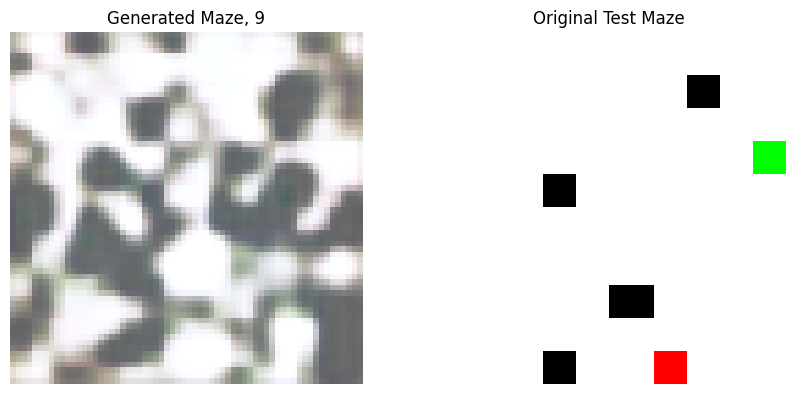

In [ ]:
generated, original, test_path_length = generate_maze_from_test(num_steps=100)
image = generated[0].detach().cpu()

# Convert from [-1, 1] to [0, 1]
image = (image + 1.0) / 2.0
generated = torch.clamp(image, 0.0, 1.0)


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(generated.squeeze(0).permute(1, 2, 0).cpu().numpy(), cmap='gray')
# plt.imshow(generated.squeeze(0).cpu().numpy(), cmap='gray')
plt.title(f"Generated Maze, {test_path_length}")
plt.axis("off")

plt.subplot(1, 2, 2)
# plt.imshow(original.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.imshow(original.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.title("Original Test Maze")
plt.axis("off")
file_name = f"diffusion_image_generation_multi_feat_{formatted_time}"
plt.savefig(os.path.join(loss_curves_folder, file_name))
plt.show()

# Diffusion - Clip + LoRa

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import UNet2DConditionModel, DDIMScheduler
from peft import LoraConfig

In [ ]:
# Hyperparams
NUM_TIMESTEPS = 1000
GUIDANCE_SCALE = 7.5
LATENT_SHAPE = (4, 64, 64)  # For SD 1.5
EPOCHS = 15

In [ ]:
unet = UNet2DConditionModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="unet").to(device)
unet.requires_grad_(False)
lora_config = LoraConfig(
        r=4,
        lora_alpha=16,
        init_lora_weights="gaussian",
        target_modules=["to_k", "to_q", "to_v", "to_out.0"],
    )
unet.add_adapter(lora_config)
lora_layers = filter(lambda p: p.requires_grad, unet.parameters())
optimizer = torch.optim.Adam(
    lora_layers, lr=1e-5, betas=(0.9, 0.999), weight_decay=1e-2, eps=1e-08)
scheduler = DDIMScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="scheduler")
custom_diffusion_model = Diffusion(input_size=2).to(device)
scheduler.set_timesteps(NUM_TIMESTEPS)
vae.eval()
tokenizer = CLIPTokenizer.from_pretrained(
    "runwayml/stable-diffusion-v1-5", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(
    "runwayml/stable-diffusion-v1-5", subfolder="text_encoder").to(device)
# optimizer = torch.optim.Adam(list(unet.parameters()), lr=1e-5)

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

Training epoch [1/15]: 100%|██████████| 157/157 [07:09<00:00,  2.73s/it]


[Epoch 1] Loss: 1.855023


Training epoch [2/15]: 100%|██████████| 157/157 [07:08<00:00,  2.73s/it]


[Epoch 2] Loss: 1.023170


Training epoch [3/15]: 100%|██████████| 157/157 [07:08<00:00,  2.73s/it]


[Epoch 3] Loss: 0.836821


Training epoch [4/15]: 100%|██████████| 157/157 [07:08<00:00,  2.73s/it]


[Epoch 4] Loss: 0.795800


Training epoch [5/15]: 100%|██████████| 157/157 [07:07<00:00,  2.73s/it]


[Epoch 5] Loss: 0.783394


Training epoch [6/15]: 100%|██████████| 157/157 [07:08<00:00,  2.73s/it]


[Epoch 6] Loss: 0.775740


Training epoch [7/15]: 100%|██████████| 157/157 [07:08<00:00,  2.73s/it]


[Epoch 7] Loss: 0.771825


Training epoch [8/15]: 100%|██████████| 157/157 [07:09<00:00,  2.73s/it]


[Epoch 8] Loss: 0.765374


Training epoch [9/15]: 100%|██████████| 157/157 [07:09<00:00,  2.73s/it]


[Epoch 9] Loss: 0.763362


Training epoch [10/15]: 100%|██████████| 157/157 [07:08<00:00,  2.73s/it]


[Epoch 10] Loss: 0.760709


Training epoch [11/15]: 100%|██████████| 157/157 [07:08<00:00,  2.73s/it]


[Epoch 11] Loss: 0.752144


Training epoch [12/15]: 100%|██████████| 157/157 [07:09<00:00,  2.73s/it]


[Epoch 12] Loss: 0.751750


Training epoch [13/15]: 100%|██████████| 157/157 [07:08<00:00,  2.73s/it]


[Epoch 13] Loss: 0.748580


Training epoch [14/15]: 100%|██████████| 157/157 [07:08<00:00,  2.73s/it]


[Epoch 14] Loss: 0.746951


Training epoch [15/15]: 100%|██████████| 157/157 [07:08<00:00,  2.73s/it]


[Epoch 15] Loss: 0.747312


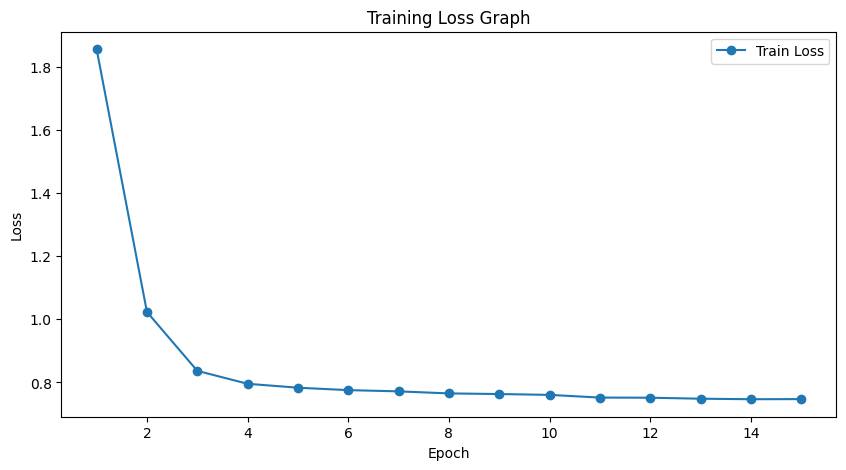

In [ ]:
train_losses = []
loss_fn = torch.nn.MSELoss()

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    count = 0

    #for batch_idx, (images, path_lengths, nodes_astar, nodes_bfs) in enumerate(tqdm(dataloader, desc=f"Training epoch [{epoch+1}/{EPOCHS}]")):
    for batch_idx, (images, prompt) in enumerate(tqdm(dataloader, desc=f"Training epoch [{epoch+1}/{EPOCHS}]")):
        unet.train()
        images = images.to(device)
        # path_lengths = path_lengths.float().to(device)
        # nodes_astar = nodes_bfs.float().to(device)

        # Step 1: Encode images to latents using VAE
        with torch.no_grad():
            z = vae.encode(images).latent_dist.sample()  # shape: (B, 4, 64, 64)

        # Step 2: Sample timesteps & add noise
        timesteps = torch.randint(0, NUM_TIMESTEPS, (z.size(0),), device=device).long()
        noise = torch.randn_like(z)
        noisy_z = scheduler.add_noise(z, noise, timesteps)

        # Step 3: Prepare conditional and unconditional embeddings
        # cond_input = torch.stack([path_lengths, nodes_astar], dim=-1)
        # cond_embed = custom_diffusion_model.condition_multidimensional_embedding(cond_input)

        # zero_input = torch.zeros_like(cond_input)
        # uncond_embed = custom_diffusion_model.condition_multidimensional_embedding(zero_input)

        # context = torch.cat([uncond_embed, cond_embed], dim=0)

        inputs = tokenizer(prompt, padding="max_length", max_length=77, return_tensors="pt").to(device)
        with torch.no_grad():
            cond_embed = text_encoder(**inputs).last_hidden_state

        # For unconditional context
        uncond_prompt = [""] * images.size(0)
        uncond_inputs = tokenizer(uncond_prompt, padding="max_length", max_length=77, return_tensors="pt").to(device)

        with torch.no_grad():
            uncond_embed = text_encoder(**uncond_inputs).last_hidden_state

        # Combine for classifier-free guidance
        context = torch.cat([uncond_embed, cond_embed], dim=0)

        # Step 4: Forward pass with classifier-free guidance
        noisy_z = noisy_z.repeat(2, 1, 1, 1)
        timesteps = timesteps.repeat_interleave(2)

        noise_pred = unet(noisy_z, timesteps, encoder_hidden_states=context).sample
        noise_uncond, noise_cond = noise_pred.chunk(2)

        guided_noise = noise_uncond + GUIDANCE_SCALE * (noise_cond - noise_uncond)

        # Step 5: Loss and optimization
        #loss = F.smooth_l1_loss(guided_noise, noise)
        loss = loss_fn(guided_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * images.size(0)
        count += images.size(0)

    avg_loss = epoch_loss / count
    train_losses.append(avg_loss)
    print(f"[Epoch {epoch+1}] Loss: {avg_loss:.6f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, marker='o', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Graph')
plt.legend()
file_name = f"loss_curve_diffusion_multi_feat_{formatted_time}"
plt.savefig(os.path.join(loss_curves_folder, file_name))
plt.show()


In [ ]:

def generate_maze_from_test(sample_idx=None, num_steps=50):
    unet.eval()
    scheduler.set_timesteps(num_steps)

    if sample_idx is None:
        sample_idx = random.randint(0, len(test_dataset) - 1)

    # test_img, test_path_length, nodes_astar, nodes_bfs = test_dataset[sample_idx]
    test_img, prompt = test_dataset[sample_idx]
    # path_tensor = torch.tensor([test_path_length]).float().to(device)
    # nodes_astar_tensor = torch.tensor([nodes_astar]).float().to(device)
    # combined_features = torch.stack((path_tensor, nodes_astar_tensor), dim=-1)
    # context = diffusion_model.condition_multidimensional_embedding(
    #     torch.tensor([test_path_length], device=device).float()
    # )

    # context = custom_diffusion_model.condition_multidimensional_embedding(combined_features)

    inputs = tokenizer(prompt, padding="max_length", max_length=77, return_tensors="pt").to(device)
    with torch.no_grad():
        context = text_encoder(**inputs).last_hidden_state

    latent = torch.randn((1, 4, 8, 8), device=device)

    for t in scheduler.timesteps:
        timestep = torch.tensor([t], device=device)
        with torch.no_grad():
            pred = unet(latent, timestep, encoder_hidden_states=context).sample
        latent = scheduler.step(pred, t, latent).prev_sample

    with torch.no_grad():
        generated_image = vae.decode(latent/0.18215).sample
        # generated_image = decoder(latent / 0.18215)

    # return generated_image, test_img, test_path_length
    return generated_image, test_img, prompt

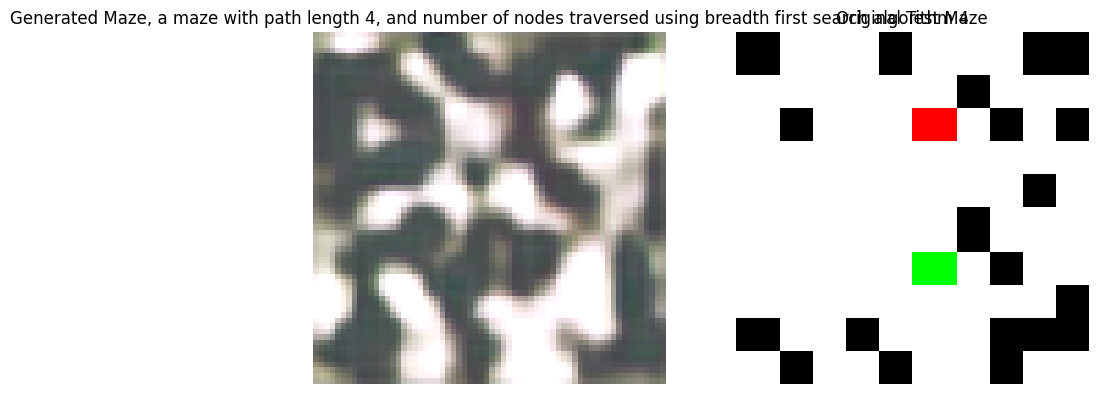

In [ ]:
generated, original, test_path_length = generate_maze_from_test(num_steps=100)
image = generated[0].detach().cpu()

# Convert from [-1, 1] to [0, 1]
image = (image + 1.0) / 2.0
generated = torch.clamp(image, 0.0, 1.0)


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(generated.squeeze(0).permute(1, 2, 0).cpu().numpy(), cmap='gray')
# plt.imshow(generated.squeeze(0).cpu().numpy(), cmap='gray')
plt.title(f"Generated Maze, {test_path_length}")
plt.axis("off")

plt.subplot(1, 2, 2)
# plt.imshow(original.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.imshow(original.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.title("Original Test Maze")
plt.axis("off")
file_name = f"diffusion_image_generation_multi_feat_{formatted_time}"
plt.savefig(os.path.join(loss_curves_folder, file_name))
plt.show()

# Inference

In [25]:
from diffusers import StableDiffusionPipeline, DiffusionPipeline
from diffusers.utils import convert_state_dict_to_diffusers
from peft import get_peft_model_state_dict

In [26]:
pipe = DiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    unet=unet,
    torch_dtype=torch.float16,  # or torch.float32
)

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [27]:
pipe.load_lora_weights(
    pretrained_model_name_or_path_or_dict=f"/content/drive/MyDrive/loss_curves_20250422_211932/lora_weights",
    #pretrained_model_name_or_path_or_dict=f"/content/drive/MyDrive/loss_curves_20250422_211932/diffusion_weights_multi_feat_lora.pth",
    adapter_name="custom_lora_1",  # optional name
    from_local=True
)
unet = pipe.unet

In [28]:
def generate_maze_from_test(sample_idx=None, num_steps=50, path_length_test = 8):
    unet.eval()
    scheduler.set_timesteps(num_steps)

    if sample_idx is None:
        sample_idx = random.randint(0, len(test_dataset) - 1)

    # for idx, (_, path_length, _, _) in enumerate(test_dataset):
    #     if path_length == path_length_test:
    #         sample_idx = idx
    #         break

    valid_indices = [idx for idx, (_, path_length, _, _) in enumerate(test_dataset) if path_length == path_length_test]
    sample_idx = random.choice(valid_indices)

    test_img, test_path_length, nodes_astar, nodes_bfs = test_dataset[sample_idx]
    path_tensor = torch.tensor([test_path_length]).float().to(device)
    nodes_astar_tensor = torch.tensor([nodes_astar]).float().to(device)
    combined_features = torch.stack((path_tensor, nodes_astar_tensor), dim=-1)
    # context = diffusion_model.condition_multidimensional_embedding(
    #     torch.tensor([test_path_length], device=device).float()
    # )

    context = custom_diffusion_model.condition_multidimensional_embedding(combined_features)

    latent = torch.randn((1, 4, 8, 8), device=device)

    for t in scheduler.timesteps:
        timestep = torch.tensor([t], device=device)
        with torch.no_grad():
            pred = unet(latent, timestep, encoder_hidden_states=context).sample
        latent = scheduler.step(pred, t, latent).prev_sample

    with torch.no_grad():
        generated_image = vae.decode(latent/0.18215).sample
        # generated_image = decoder(latent / 0.18215)

    return generated_image, test_img, test_path_length

Red range: 0.46048665 1.0
Green range: 0.4673581 1.0
Blue range: 0.45957693 1.0


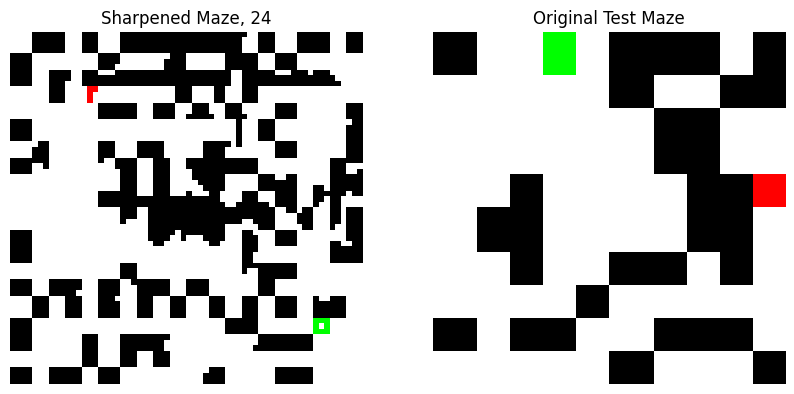

In [103]:
generated, original, test_path_length = generate_maze_from_test(num_steps=5, path_length_test = 24)
image = generated[0].detach().cpu()

# Convert from [-1, 1] to [0, 1]
image = (image + 1.0) / 2.0
generated = torch.clamp(image, 0.0, 1.0)

#Simple threshold
def apply_relaxed_threshold(image):
    r, g, b = image[..., 0], image[..., 1], image[..., 2]

    # Relaxed black: any dark-ish area
    black_mask = (r < 0.7) & (g < 0.7) & (b < 0.7)

    # Relaxed red and green
    red_mask = (r > 0.8) & (g < 0.6) & (b < 0.6)
    green_mask = (g > 0.8) & (r < 0.6) & (b < 0.6)

    # Initialize white
    new_image = np.ones_like(image)

    new_image[black_mask] = [0.0, 0.0, 0.0]
    new_image[red_mask] = [1.0, 0.0, 0.0]
    new_image[green_mask] = [0.0, 1.0, 0.0]

    return new_image

#Thicken edge, too bad tho
from scipy.ndimage import binary_dilation

def apply_relaxed_threshold_with_thickening(image):
    r, g, b = image[..., 0], image[..., 1], image[..., 2]

    # Masks
    black_mask = (r < 0.7) & (g < 0.7) & (b < 0.7)
    red_mask = (r > 0.8) & (g < 0.6) & (b < 0.6)
    green_mask = (g > 0.8) & (r < 0.6) & (b < 0.6)

    # Thicken black walls
    thick_black = binary_dilation(black_mask, structure=np.ones((3, 3)))

    # Create final RGB image
    new_image = np.ones_like(image)  # White base
    new_image[thick_black] = [0.0, 0.0, 0.0]
    new_image[red_mask] = [1.0, 0.0, 0.0]
    new_image[green_mask] = [0.0, 1.0, 0.0]

    return new_image

#Keep largest cluster
from scipy.ndimage import label, find_objects

def keep_largest_colored_cluster(image):
    r, g, b = image[..., 0], image[..., 1], image[..., 2]

    # Boolean masks
    red_mask = (r > 0.8) & (g < 0.6) & (b < 0.6)
    green_mask = (g > 0.8) & (r < 0.6) & (b < 0.6)
    black_mask = (r < 0.7) & (g < 0.7) & (b < 0.7)

    def get_largest_component(mask):
        labeled, num = label(mask)
        if num == 0:
            return mask  # No components found
        sizes = [(labeled == i).sum() for i in range(1, num + 1)]
        largest_label = np.argmax(sizes) + 1
        return labeled == largest_label

    largest_red = get_largest_component(red_mask)
    largest_green = get_largest_component(green_mask)

    new_image = np.ones_like(image)  # Start with white
    new_image[black_mask] = [0.0, 0.0, 0.0]
    new_image[largest_red] = [1.0, 0.0, 0.0]
    new_image[largest_green] = [0.0, 1.0, 0.0]

    return new_image

#Noise cleanup
from scipy.ndimage import label

def filter_small_black_regions(image, min_size=10):
    r, g, b = image[..., 0], image[..., 1], image[..., 2]

    # Identify black pixels
    black_mask = (r < 0.3) & (g < 0.3) & (b < 0.3)
    labeled, num_features = label(black_mask)

    # Count pixels in each component
    sizes = [(labeled == i).sum() for i in range(1, num_features + 1)]

    # Create new black mask keeping only large components
    large_black_mask = np.zeros_like(black_mask)
    for i, size in enumerate(sizes):
        if size >= min_size:
            large_black_mask[labeled == (i + 1)] = True

    # Reconstruct image: all others to white
    new_image = np.ones_like(image)  # white base
    new_image[large_black_mask] = [0.0, 0.0, 0.0]
    new_image[(r > 0.8) & (g < 0.5)] = [1.0, 0.0, 0.0]  # red
    new_image[(g > 0.8) & (r < 0.5)] = [0.0, 1.0, 0.0]  # green

    return new_image

#Morphological erosion
import cv2

def erode_black_walls(image, kernel_size=3, iterations=1):
    r, g, b = image[..., 0], image[..., 1], image[..., 2]

    black_mask = ((r < 0.3) & (g < 0.3) & (b < 0.3)).astype(np.uint8)
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    eroded_mask = cv2.erode(black_mask, kernel, iterations=iterations)

    # Rebuild image with reduced walls
    new_image = np.ones_like(image)
    new_image[eroded_mask == 1] = [0.0, 0.0, 0.0]
    new_image[(r > 0.8) & (g < 0.5)] = [1.0, 0.0, 0.0]
    new_image[(g > 0.8) & (r < 0.5)] = [0.0, 1.0, 0.0]

    return new_image


generated_np = generated.squeeze(0).permute(1, 2, 0).numpy()
print("Red range:", generated_np[..., 0].min(), generated_np[..., 0].max())
print("Green range:", generated_np[..., 1].min(), generated_np[..., 1].max())
print("Blue range:", generated_np[..., 2].min(), generated_np[..., 2].max())

# After you clamp the image:
generated_np = generated.squeeze(0).permute(1, 2, 0).numpy()
sharpened_image = apply_relaxed_threshold(generated_np)
sharpened_image = keep_largest_colored_cluster(sharpened_image)
sharpened_image = filter_small_black_regions(sharpened_image)
#sharpened_image = apply_relaxed_threshold_with_thickening(generated_np)

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sharpened_image)
plt.title(f"Sharpened Maze, {test_path_length}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(original.permute(1, 2, 0).cpu().numpy())
plt.title("Original Test Maze")
plt.axis("off")

plt.show()


In [30]:
generated_images = []
original_images = []

In [104]:
generated_images.append(sharpened_image)
original_images.append(original)

In [151]:
import os
from PIL import Image
import numpy as np

# Directory to save
save_dir = "saved_mazes_batch"
os.makedirs(save_dir, exist_ok=True)

# Loop through the batch
for idx, img_tensor in enumerate(generated_images):  # generated: shape (B, C, H, W)
    # Move to CPU, clamp to [0, 1], convert to HWC format
    img = img_tensor
    img = np.clip(img, 0, 1)

    # Optional: apply sharpening / cleanup if needed here

    # Convert to uint8 for saving
    img_uint8 = (img * 255).astype(np.uint8)

    # Save as PNG
    Image.fromarray(img_uint8).save(os.path.join(save_dir, f"maze_{idx:03d}.png"))


In [152]:
!zip -r saved_mazes_batch.zip saved_mazes_batch


  adding: saved_mazes_batch/ (stored 0%)
  adding: saved_mazes_batch/maze_001.png (stored 0%)
  adding: saved_mazes_batch/maze_009.png (stored 0%)
  adding: saved_mazes_batch/maze_002.png (deflated 9%)
  adding: saved_mazes_batch/maze_004.png (stored 0%)
  adding: saved_mazes_batch/maze_006.png (stored 0%)
  adding: saved_mazes_batch/maze_005.png (stored 0%)
  adding: saved_mazes_batch/maze_008.png (stored 0%)
  adding: saved_mazes_batch/maze_003.png (stored 0%)
  adding: saved_mazes_batch/maze_007.png (deflated 5%)
  adding: saved_mazes_batch/maze_000.png (stored 0%)


In [99]:
len(generated_images)

1

## Stepwise gen

In [ ]:
grid_images = []

Red range: 0.47220984 1.0
Green range: 0.48800796 1.0
Blue range: 0.48858884 1.0


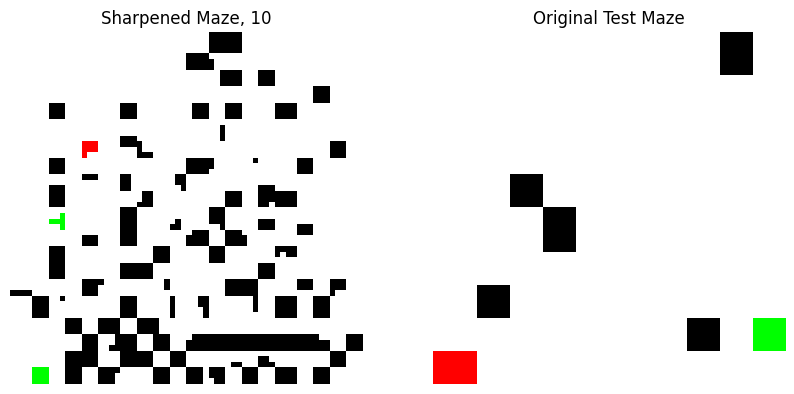

In [ ]:
generated, original, test_path_length = generate_maze_from_test(num_steps=5, path_length_test = 10)
image = generated[0].detach().cpu()

# Convert from [-1, 1] to [0, 1]
image = (image + 1.0) / 2.0
generated = torch.clamp(image, 0.0, 1.0)

#Simple threshold
def apply_relaxed_threshold(image):
    r, g, b = image[..., 0], image[..., 1], image[..., 2]

    # Relaxed black: any dark-ish area
    black_mask = (r < 0.7) & (g < 0.7) & (b < 0.7)

    # Relaxed red and green
    red_mask = (r > 0.8) & (g < 0.6) & (b < 0.6)
    green_mask = (g > 0.8) & (r < 0.6) & (b < 0.6)

    # Initialize white
    new_image = np.ones_like(image)

    new_image[black_mask] = [0.0, 0.0, 0.0]
    new_image[red_mask] = [1.0, 0.0, 0.0]
    new_image[green_mask] = [0.0, 1.0, 0.0]

    return new_image

#Thicken edge, too bad tho
from scipy.ndimage import binary_dilation

def apply_relaxed_threshold_with_thickening(image):
    r, g, b = image[..., 0], image[..., 1], image[..., 2]

    # Masks
    black_mask = (r < 0.7) & (g < 0.7) & (b < 0.7)
    red_mask = (r > 0.8) & (g < 0.6) & (b < 0.6)
    green_mask = (g > 0.8) & (r < 0.6) & (b < 0.6)

    # Thicken black walls
    thick_black = binary_dilation(black_mask, structure=np.ones((3, 3)))

    # Create final RGB image
    new_image = np.ones_like(image)  # White base
    new_image[thick_black] = [0.0, 0.0, 0.0]
    new_image[red_mask] = [1.0, 0.0, 0.0]
    new_image[green_mask] = [0.0, 1.0, 0.0]

    return new_image

#Keep largest cluster
from scipy.ndimage import label, find_objects

def keep_largest_colored_cluster(image):
    r, g, b = image[..., 0], image[..., 1], image[..., 2]

    # Boolean masks
    red_mask = (r > 0.8) & (g < 0.6) & (b < 0.6)
    green_mask = (g > 0.8) & (r < 0.6) & (b < 0.6)
    black_mask = (r < 0.7) & (g < 0.7) & (b < 0.7)

    def get_largest_component(mask):
        labeled, num = label(mask)
        if num == 0:
            return mask  # No components found
        sizes = [(labeled == i).sum() for i in range(1, num + 1)]
        largest_label = np.argmax(sizes) + 1
        return labeled == largest_label

    largest_red = get_largest_component(red_mask)
    largest_green = get_largest_component(green_mask)

    new_image = np.ones_like(image)  # Start with white
    new_image[black_mask] = [0.0, 0.0, 0.0]
    new_image[largest_red] = [1.0, 0.0, 0.0]
    new_image[largest_green] = [0.0, 1.0, 0.0]

    return new_image

#Noise cleanup
from scipy.ndimage import label

def filter_small_black_regions(image, min_size=10):
    r, g, b = image[..., 0], image[..., 1], image[..., 2]

    # Identify black pixels
    black_mask = (r < 0.3) & (g < 0.3) & (b < 0.3)
    labeled, num_features = label(black_mask)

    # Count pixels in each component
    sizes = [(labeled == i).sum() for i in range(1, num_features + 1)]

    # Create new black mask keeping only large components
    large_black_mask = np.zeros_like(black_mask)
    for i, size in enumerate(sizes):
        if size >= min_size:
            large_black_mask[labeled == (i + 1)] = True

    # Reconstruct image: all others to white
    new_image = np.ones_like(image)  # white base
    new_image[large_black_mask] = [0.0, 0.0, 0.0]
    new_image[(r > 0.8) & (g < 0.5)] = [1.0, 0.0, 0.0]  # red
    new_image[(g > 0.8) & (r < 0.5)] = [0.0, 1.0, 0.0]  # green

    return new_image

#Morphological erosion
import cv2

def erode_black_walls(image, kernel_size=3, iterations=1):
    r, g, b = image[..., 0], image[..., 1], image[..., 2]

    black_mask = ((r < 0.3) & (g < 0.3) & (b < 0.3)).astype(np.uint8)
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    eroded_mask = cv2.erode(black_mask, kernel, iterations=iterations)

    # Rebuild image with reduced walls
    new_image = np.ones_like(image)
    new_image[eroded_mask == 1] = [0.0, 0.0, 0.0]
    new_image[(r > 0.8) & (g < 0.5)] = [1.0, 0.0, 0.0]
    new_image[(g > 0.8) & (r < 0.5)] = [0.0, 1.0, 0.0]

    return new_image


generated_np = generated.squeeze(0).permute(1, 2, 0).numpy()
print("Red range:", generated_np[..., 0].min(), generated_np[..., 0].max())
print("Green range:", generated_np[..., 1].min(), generated_np[..., 1].max())
print("Blue range:", generated_np[..., 2].min(), generated_np[..., 2].max())

# After you clamp the image:
generated_np = generated.squeeze(0).permute(1, 2, 0).numpy()
sharpened_image = apply_relaxed_threshold(generated_np)
#sharpened_image = apply_relaxed_threshold_with_thickening(generated_np)
grid_images.append(sharpened_image)
# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sharpened_image)
plt.title(f"Sharpened Maze, {test_path_length}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(original.permute(1, 2, 0).cpu().numpy())
plt.title("Original Test Maze")
plt.axis("off")

plt.show()


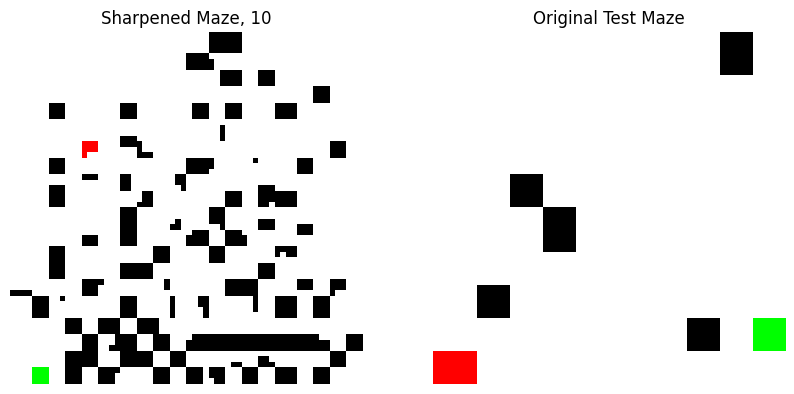

In [ ]:
sharpened_image = keep_largest_colored_cluster(sharpened_image)
#sharpened_image = apply_relaxed_threshold_with_thickening(generated_np)
grid_images.append(sharpened_image)

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sharpened_image)
plt.title(f"Sharpened Maze, {test_path_length}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(original.permute(1, 2, 0).cpu().numpy())
plt.title("Original Test Maze")
plt.axis("off")

plt.show()

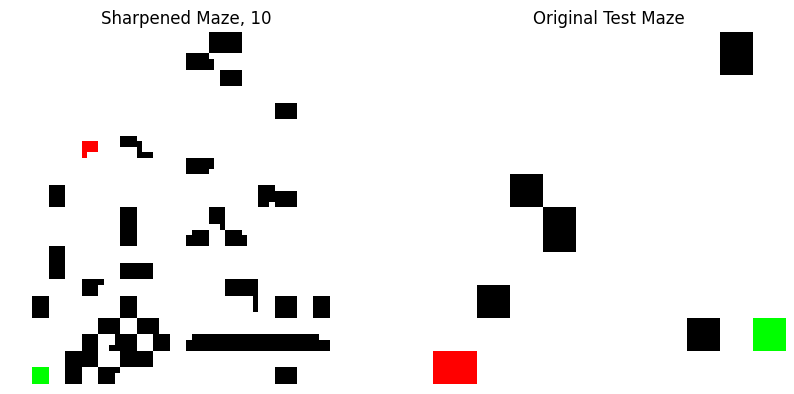

In [ ]:
sharpened_image = filter_small_black_regions(sharpened_image)
#sharpened_image = apply_relaxed_threshold_with_thickening(generated_np)
grid_images.append(sharpened_image)

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sharpened_image)
plt.title(f"Sharpened Maze, {test_path_length}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(original.permute(1, 2, 0).cpu().numpy())
plt.title("Original Test Maze")
plt.axis("off")

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_image_sharpening_pipeline(original, thresholded, clustered, denoised):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle("Image Sharpening", fontsize=16)

    titles = [
        "Generated Image",
        "After Thresholding",
        "Largest Cluster Selected",
        "Speckle Noise Removed"
    ]
    images = [original, thresholded, clustered, denoised]

    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Give space for overall title
    plt.show()


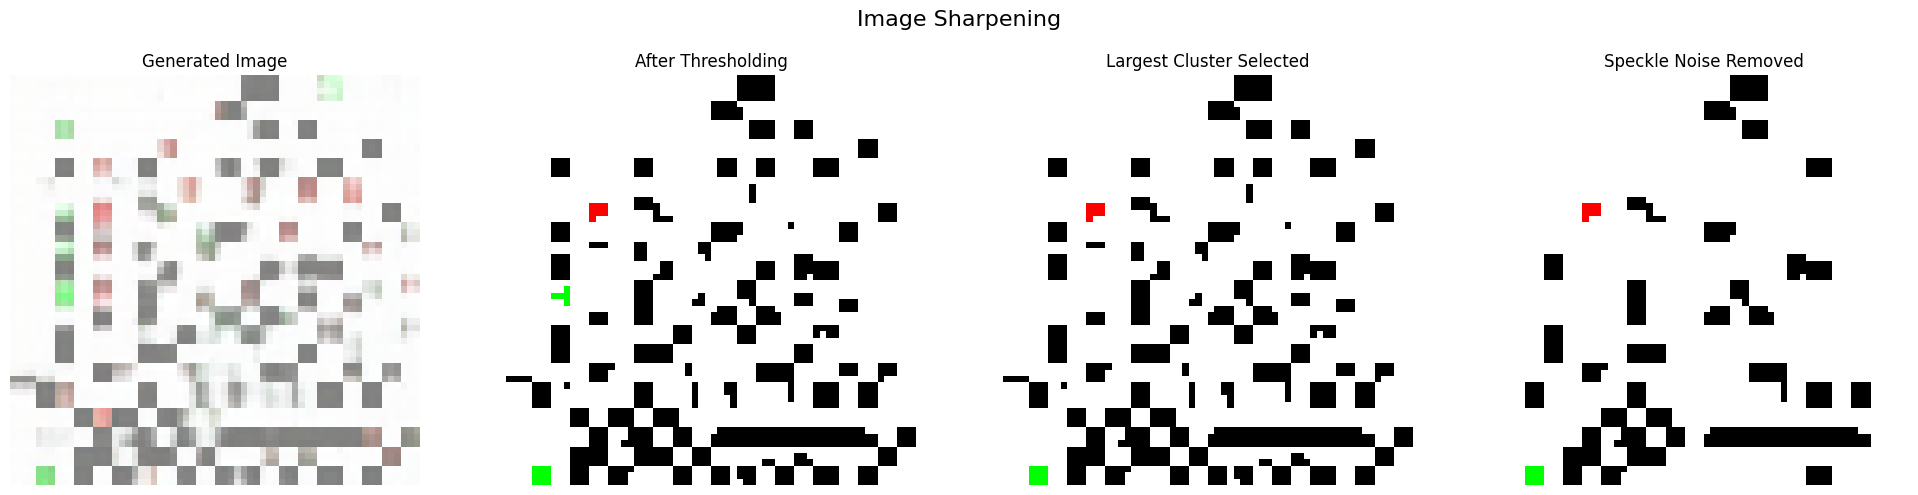

In [ ]:

plot_image_sharpening_pipeline(
    original=generated_np,
    thresholded=grid_images[0],
    clustered=grid_images[1],
    denoised=grid_images[2]
)

## Grids

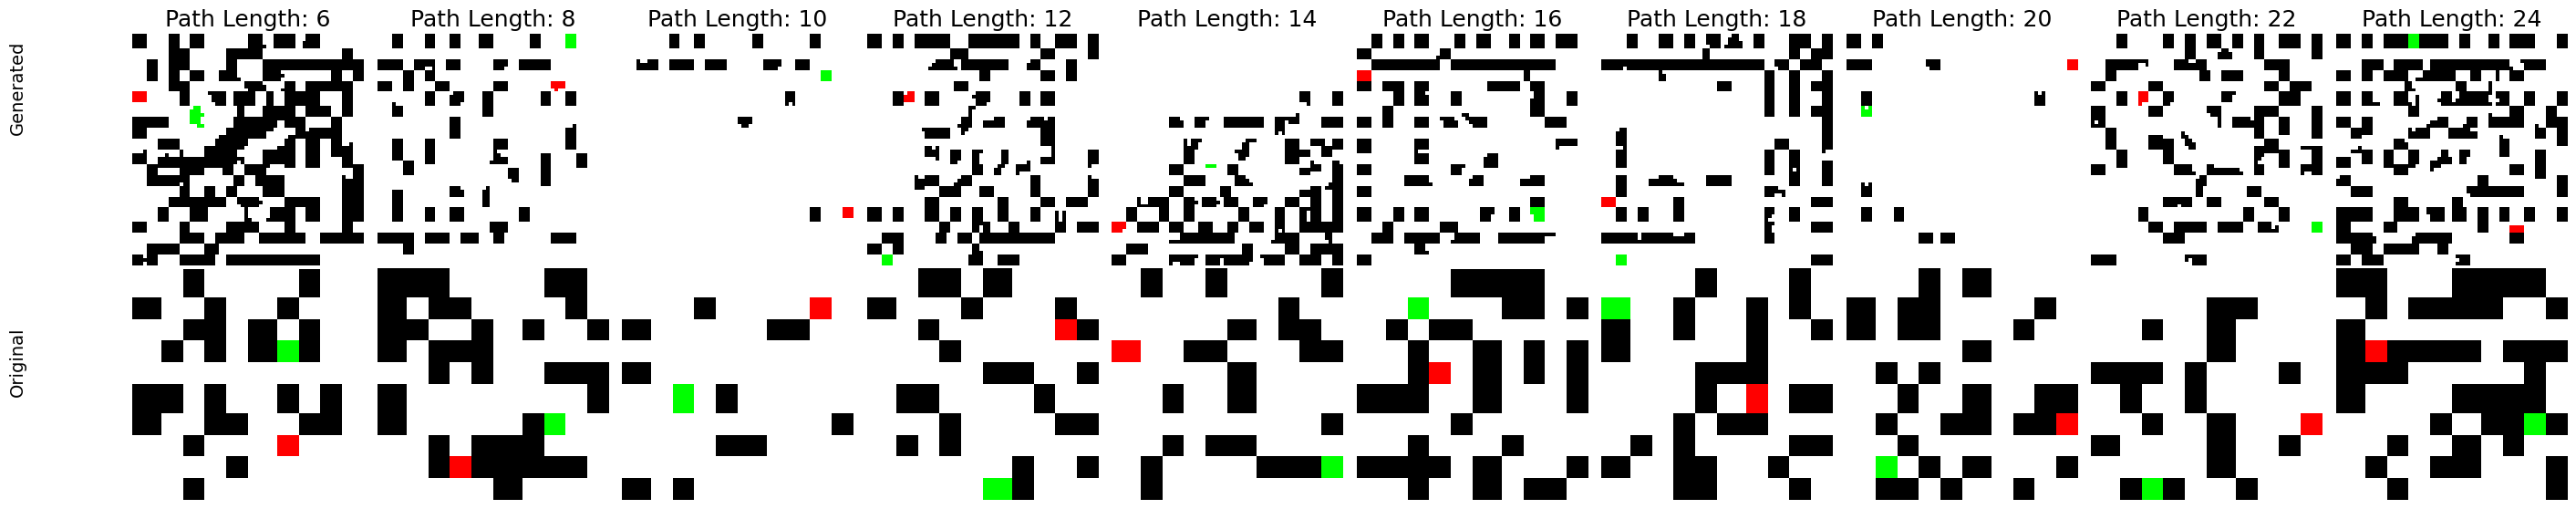

In [153]:
# Plotting
def plot_maze_grid(generated_images, original_images, path_lengths):
    num_samples = len(generated_images)
    fig, axes = plt.subplots(2, num_samples, figsize=(3*num_samples, 6))

    # Top row: Generated images
    for i in range(num_samples):
        ax = axes[0, i]
        ax.imshow(generated_images[i])
        ax.set_title(f"Path Length: {path_lengths[i]}", fontsize=18)
        ax.axis("off")
    axes[0, 0].set_ylabel("Generated Mazes", fontsize=12)

    # Bottom row: Original images
    for i in range(num_samples):
        ax = axes[1, i]
        ax.imshow(original_images[i].permute(1, 2, 0).cpu().numpy())
        ax.axis("off")
    axes[1, 0].set_ylabel("Original Mazes", fontsize=12)

    plt.figtext(0.06, 0.78, "Generated", fontsize=14, rotation='vertical', va='center')
    plt.figtext(0.06, 0.28, "Original", fontsize=14, rotation='vertical', va='center')
    plt.tight_layout(rect=[0.1, 0, 1, 1])
    plt.subplots_adjust(top=0.88)
    plt.show()

# Call plotting
found_lengths = [6,8,10,12,14,16,18,20,22,24]
plot_maze_grid(generated_images, original_images, found_lengths)

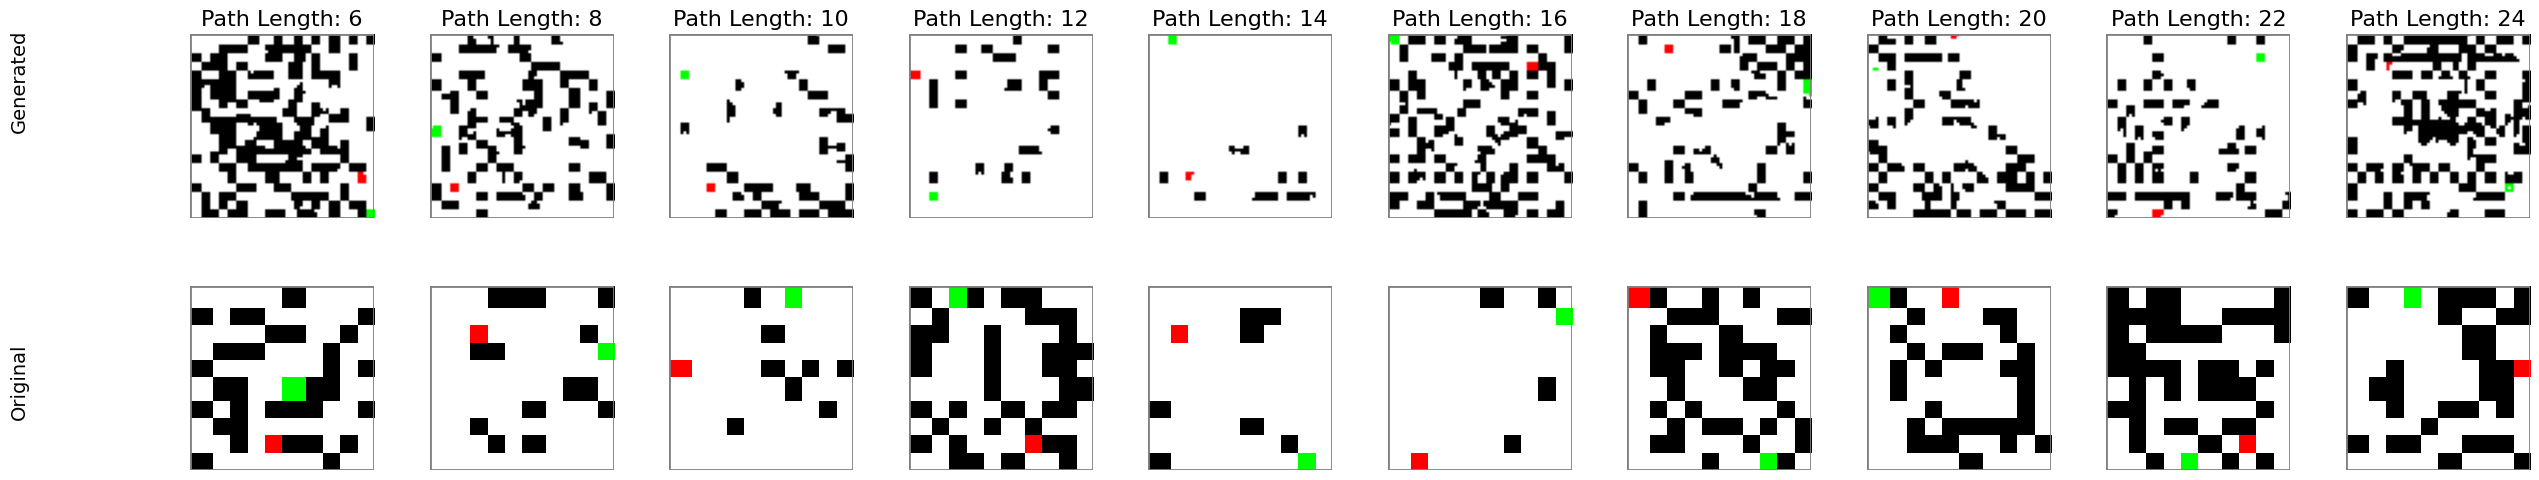

In [107]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_maze_grid(generated_images, original_images, path_lengths):
    num_samples = len(generated_images)
    fig, axes = plt.subplots(2, num_samples, figsize=(3*num_samples, 6))

    for i in range(num_samples):
        # Top row: Generated images
        ax = axes[0, i]
        ax.imshow(generated_images[i])
        ax.set_title(f"Path Length: {path_lengths[i]}", fontsize=16)
        ax.axis("off")
        ax.add_patch(Rectangle((0, 0), 1, 1, transform=ax.transAxes,
                               edgecolor='gray', fill=False, linewidth=2))

        # Bottom row: Original images
        ax = axes[1, i]
        ax.imshow(original_images[i].permute(1, 2, 0).cpu().numpy())
        ax.axis("off")
        ax.add_patch(Rectangle((0, 0), 1, 1, transform=ax.transAxes,
                               edgecolor='gray', fill=False, linewidth=2))

    axes[0, 0].set_ylabel("Generated Mazes", fontsize=12)
    axes[1, 0].set_ylabel("Original Mazes", fontsize=12)

    plt.figtext(0.06, 0.78, "Generated", fontsize=14, rotation='vertical', va='center')
    plt.figtext(0.06, 0.28, "Original", fontsize=14, rotation='vertical', va='center')

    plt.subplots_adjust(wspace=0.3, hspace=0.2, top=0.88, left=0.12)
    plt.show()

# Call plotting
found_lengths = [6,8,10,12,14,16,18,20,22,24]
plot_maze_grid(generated_images, original_images, found_lengths)

#Using saved images

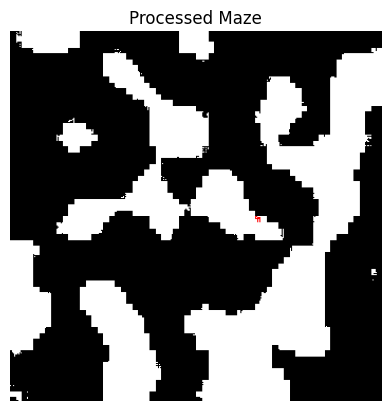

True

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label

# 1. Enhance color saturation to help with red/green recovery
def enhance_saturation(image, saturation_scale=2.0):
    image_uint8 = (image * 255).astype(np.uint8)
    hsv = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2HSV).astype(np.float32)
    hsv[..., 1] *= saturation_scale
    hsv[..., 1] = np.clip(hsv[..., 1], 0, 255)
    enhanced_rgb = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)
    return enhanced_rgb / 255.0

# 2. Relaxed thresholding
def apply_relaxed_threshold(image):
    r, g, b = image[..., 0], image[..., 1], image[..., 2]
    black_mask = (r < 0.7) & (g < 0.7) & (b < 0.7)
    red_mask = (r > 0.8) & (g < 0.6) & (b < 0.6)
    green_mask = (g > 0.8) & (r < 0.6) & (b < 0.6)
    new_image = np.ones_like(image)
    new_image[black_mask] = [0.0, 0.0, 0.0]
    new_image[red_mask] = [1.0, 0.0, 0.0]
    new_image[green_mask] = [0.0, 1.0, 0.0]
    return new_image

# 3. Keep only the largest red and green clusters
def keep_largest_colored_cluster(image):
    r, g, b = image[..., 0], image[..., 1], image[..., 2]
    red_mask = (r > 0.8) & (g < 0.6) & (b < 0.6)
    green_mask = (g > 0.8) & (r < 0.6) & (b < 0.6)
    black_mask = (r < 0.7) & (g < 0.7) & (b < 0.7)

    def get_largest_component(mask):
        labeled, num = label(mask)
        if num == 0:
            return mask
        sizes = [(labeled == i).sum() for i in range(1, num + 1)]
        largest_label = np.argmax(sizes) + 1
        return labeled == largest_label

    largest_red = get_largest_component(red_mask)
    largest_green = get_largest_component(green_mask)

    new_image = np.ones_like(image)
    new_image[black_mask] = [0.0, 0.0, 0.0]
    new_image[largest_red] = [1.0, 0.0, 0.0]
    new_image[largest_green] = [0.0, 1.0, 0.0]

    return new_image

# 4. Clean up small black noise
def filter_small_black_regions(image, min_size=10):
    r, g, b = image[..., 0], image[..., 1], image[..., 2]
    black_mask = (r < 0.3) & (g < 0.3) & (b < 0.3)
    labeled, num_features = label(black_mask)
    sizes = [(labeled == i).sum() for i in range(1, num_features + 1)]

    large_black_mask = np.zeros_like(black_mask)
    for i, size in enumerate(sizes):
        if size >= min_size:
            large_black_mask[labeled == (i + 1)] = True

    new_image = np.ones_like(image)
    new_image[large_black_mask] = [0.0, 0.0, 0.0]
    new_image[(r > 0.8) & (g < 0.5)] = [1.0, 0.0, 0.0]
    new_image[(g > 0.8) & (r < 0.5)] = [0.0, 1.0, 0.0]

    return new_image


def process_png_maze(image_path, min_black_size=10):
    # Load and normalize image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype(np.float32) / 255.0

    # Pipeline
    img = enhance_saturation(image, saturation_scale=2.5)
    thresholded = apply_relaxed_threshold(img)
    #thresholded = apply_strong_color_threshold(image)
    largest_clusters = keep_largest_colored_cluster(thresholded)
    final_image = filter_small_black_regions(largest_clusters, min_size=min_black_size)

    return final_image

# Example Usage
processed = process_png_maze("/content/BFS_1_Unprocessed_MSE_Cropped.jpg", min_black_size=10)


plt.imshow(processed)
plt.title("Processed Maze")
plt.axis("off")
plt.show()

# Optionally save
cv2.imwrite("sharpened_output.png", cv2.cvtColor((processed * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label

# Step 1: Adjust contrast
def adjust_contrast(image, factor=1.5):
    mean = np.mean(image, axis=(0, 1), keepdims=True)
    return np.clip((image - mean) * factor + mean, 0, 1)

# Step 2: Enhance saturation to help with color separation
def enhance_saturation(image, saturation_scale=3.0):
    image_uint8 = (image * 255).astype(np.uint8)
    hsv = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2HSV).astype(np.float32)
    hsv[..., 1] *= saturation_scale
    hsv[..., 1] = np.clip(hsv[..., 1], 0, 255)
    enhanced_rgb = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)
    return enhanced_rgb / 255.0

# Step 3: Relaxed thresholding using channel dominance
def apply_relaxed_threshold(image):
    r, g, b = image[..., 0], image[..., 1], image[..., 2]
    black_mask = (r < 0.6) & (g < 0.6) & (b < 0.6)
    red_mask = (r - np.maximum(g, b)) > 0.15
    green_mask = (g - np.maximum(r, b)) > 0.15

    new_image = np.ones_like(image)
    new_image[black_mask] = [0.0, 0.0, 0.0]
    new_image[red_mask] = [1.0, 0.0, 0.0]
    new_image[green_mask] = [0.0, 1.0, 0.0]
    return new_image

def keep_largest_colored_cluster(image):
    r, g, b = image[..., 0], image[..., 1], image[..., 2]
    red_mask = (r > 0.8) & (g < 0.6) & (b < 0.6)
    green_mask = (g > 0.8) & (r < 0.6) & (b < 0.6)
    black_mask = (r < 0.7) & (g < 0.7) & (b < 0.7)

    def get_largest_component(mask):
        labeled, num = label(mask)
        if num == 0:
            return mask
        sizes = [(labeled == i).sum() for i in range(1, num + 1)]
        largest_label = np.argmax(sizes) + 1
        return labeled == largest_label

    largest_red = get_largest_component(red_mask)
    largest_green = get_largest_component(green_mask)

    new_image = np.ones_like(image)
    new_image[black_mask] = [0.0, 0.0, 0.0]
    new_image[largest_red] = [1.0, 0.0, 0.0]
    new_image[largest_green] = [0.0, 1.0, 0.0]

    return new_image

# Step 4: Optional – filter small black blobs
def filter_small_black_regions(image, min_size=10):
    r, g, b = image[..., 0], image[..., 1], image[..., 2]
    black_mask = (r < 0.3) & (g < 0.3) & (b < 0.3)
    labeled, num_features = label(black_mask)
    sizes = [(labeled == i).sum() for i in range(1, num_features + 1)]

    large_black_mask = np.zeros_like(black_mask)
    for i, size in enumerate(sizes):
        if size >= min_size:
            large_black_mask[labeled == (i + 1)] = True

    new_image = np.ones_like(image)
    new_image[large_black_mask] = [0.0, 0.0, 0.0]
    new_image[(r > 0.8) & (g < 0.5)] = [1.0, 0.0, 0.0]
    new_image[(g > 0.8) & (r < 0.5)] = [0.0, 1.0, 0.0]

    return new_image

# Pipeline
def process_png_maze(image_path, min_black_size=10):
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype(np.float32) / 255.0

    # Apply processing pipeline
    image = adjust_contrast(image, factor=1.5)
    image = enhance_saturation(image, saturation_scale=3.0)
    thresholded = apply_relaxed_threshold(image)
    #cleaned = filter_small_black_regions(thresholded, min_size=min_black_size)
    cleaned = keep_largest_colored_cluster(thresholded)
    #cleaned = thresholded
    return cleaned


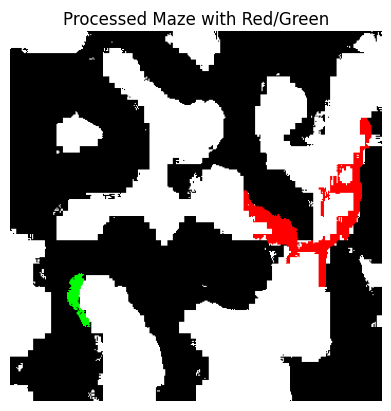

True

In [ ]:
# Run it
image_path = "/content/BFS_1_Unprocessed_MSE_Cropped.jpg"
processed = process_png_maze(image_path, min_black_size=10)

# Show result
plt.imshow(processed)
plt.title("Processed Maze with Red/Green")
plt.axis("off")
plt.show()

# Save result
cv2.imwrite("sharpened_colored_maze_bfs_mse.png", cv2.cvtColor((processed * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))

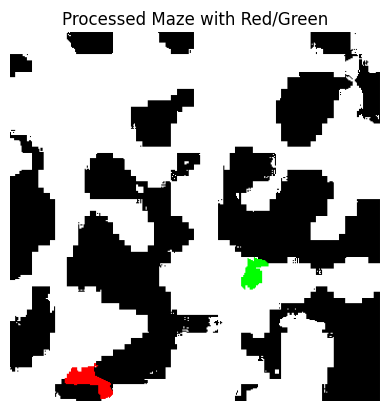

True

In [ ]:
# Run it
image_path = "/content/BFS_1_Unprocessed_Cropped.jpg"
processed = process_png_maze(image_path, min_black_size=10)

# Show result
plt.imshow(processed)
plt.title("Processed Maze with Red/Green")
plt.axis("off")
plt.show()

# Save result
cv2.imwrite("sharpened_colored_maze_bfs.png", cv2.cvtColor((processed * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))

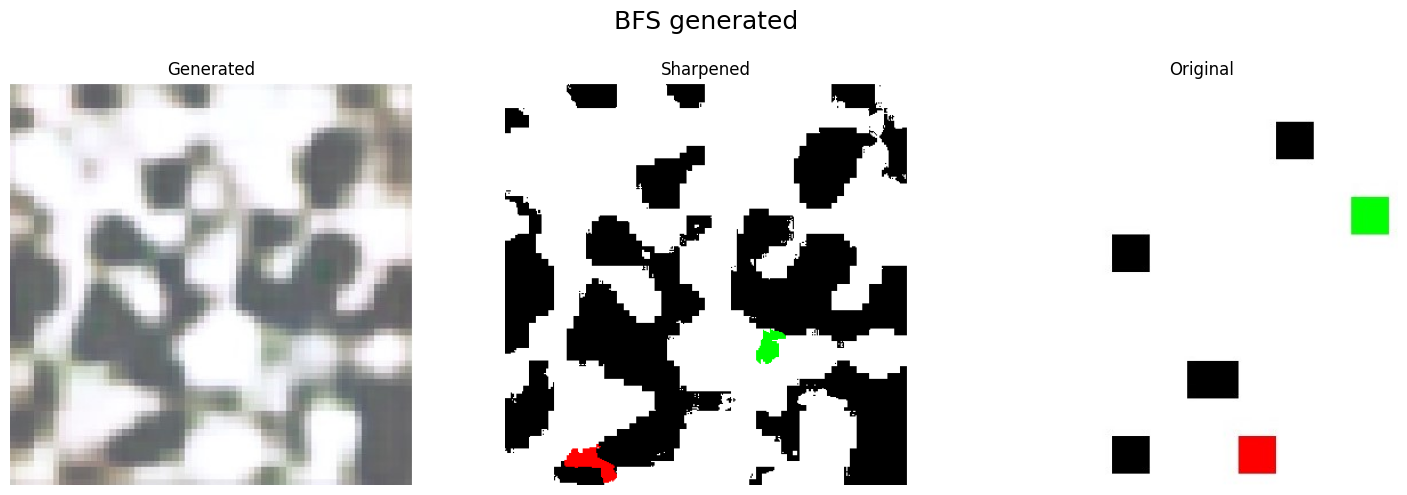

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Load your images from file (replace paths with your actual desktop paths)
original = cv2.imread(r"/content/BFS_Original.jpg")
sharpened = cv2.imread(r"/content/sharpened_colored_maze_bfs.png")
generated = cv2.imread(r"/content/BFS_1_Unprocessed_Cropped.jpg")

# Convert from BGR (OpenCV) to RGB (Matplotlib)
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
sharpened = cv2.cvtColor(sharpened, cv2.COLOR_BGR2RGB)
generated = cv2.cvtColor(generated, cv2.COLOR_BGR2RGB)

# Plot images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("BFS generated", fontsize=18)

titles = ['Generated', 'Sharpened', 'Original']
images = [generated, sharpened, original]

for ax, img, title in zip(axs, images, titles):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle
plt.show()


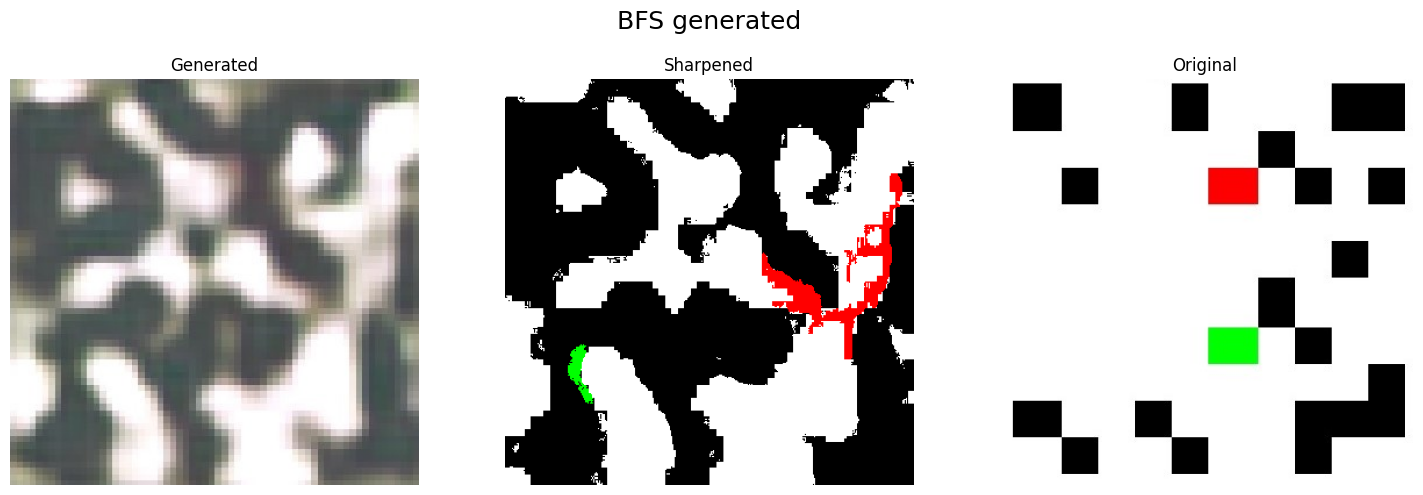

In [ ]:
# Load your images from file (replace paths with your actual desktop paths)
original = cv2.imread(r"/content/BFS_Original_MSE.jpg")
sharpened = cv2.imread(r"/content/sharpened_colored_maze_bfs_mse.png")
generated = cv2.imread(r"/content/BFS_1_Unprocessed_MSE_Cropped.jpg")

# Convert from BGR (OpenCV) to RGB (Matplotlib)
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
sharpened = cv2.cvtColor(sharpened, cv2.COLOR_BGR2RGB)
generated = cv2.cvtColor(generated, cv2.COLOR_BGR2RGB)

# Plot images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("BFS generated", fontsize=18)

titles = ['Generated', 'Sharpened', 'Original']
images = [generated, sharpened, original]

for ax, img, title in zip(axs, images, titles):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle
plt.show()